In [113]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import hj_reachability as hj
from hj_reachability import sets
from hj_reachability import dynamics
import jax.random as random

In [114]:
"""
Receding Horizon Hamilton-Jacobi-Isaacs (RH-HJI) Reachability Framework
-------------------------------------------------------------------------

This notebook implements a receding horizon approach to Hamilton-Jacobi-Isaacs (HJI) reachability for real-time decision making and planning in dynamic environments. Traditional HJI reachability provides powerful safety and goal-reaching guarantees, but suffers from high computational costs when applied globally. This work addresses that limitation through local patch extraction and update mechanisms.

Key Features:
- Extracts local patches from a globally precomputed HJI value function.
- Efficiently updates these patches over a receding horizon using dynamic programming.
- Enables rapid adaptation to changes in goals, obstacles, or dynamics.

Future 
- Integrate with control strategies (e.g., MPPI) for practical, real-time applications.
- Visualizes evolving value functions and agent trajectories through interactive animations.

This framework is ideal for scenarios requiring real-time safety-aware navigation, such as robotics, autonomous driving, or dynamic task execution. It is built on top of the `hj_reachability` JAX library, ensuring high-performance GPU/TPU acceleration.

"""


'\nReceding Horizon Hamilton-Jacobi-Isaacs (RH-HJI) Reachability Framework\n-------------------------------------------------------------------------\n\nThis notebook implements a receding horizon approach to Hamilton-Jacobi-Isaacs (HJI) reachability for real-time decision making and planning in dynamic environments. Traditional HJI reachability provides powerful safety and goal-reaching guarantees, but suffers from high computational costs when applied globally. This work addresses that limitation through local patch extraction and update mechanisms.\n\nKey Features:\n- Extracts local patches from a globally precomputed HJI value function.\n- Efficiently updates these patches over a receding horizon using dynamic programming.\n- Enables rapid adaptation to changes in goals, obstacles, or dynamics.\n\nFuture \n- Integrate with control strategies (e.g., MPPI) for practical, real-time applications.\n- Visualizes evolving value functions and agent trajectories through interactive animatio

In [115]:
class Unicycle(dynamics.ControlAndDisturbanceAffineDynamics):
    def __init__(self,
                 control_mode="min",
                 disturbance_mode="max",
                 control_space=None,
                 disturbance_space=None):
       
        # Default bounds for control: v ∈ [-1, 1], ω ∈ [-1, 1]
        if control_space is None:
            control_space = sets.Box(
                jnp.array([-1.0, -1.0]),
                jnp.array([1.0, 1.0])
            )

        # Default bounds for disturbance: v ∈ [-0.2, 0.2], ω ∈ [-0.1, 0.1]
        if disturbance_space is None:
            disturbance_space = sets.Box(
                jnp.array([-0.2, -0.1]),
                jnp.array([0.2, 0.1])
            )
        self.control_dim = 2 # [v, omega]
        
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def step(self, state, u, dt=0.1):
        """
        Applies one step of unicycle dynamics: 
            x' = x + v*cos(θ)*dt
            y' = y + v*sin(θ)*dt
            θ' = θ + ω*dt
        """
        x, y, theta = state
        v, omega = u

        dx = v * jnp.cos(theta)
        dy = v * jnp.sin(theta)
        dtheta = omega

        next_state = jnp.array([
            x + dx * dt,
            y + dy * dt,
            theta + dtheta * dt
        ])
        return next_state


    def open_loop_dynamics(self, state, time):
        return jnp.zeros_like(state)

    def control_jacobian(self, state, time):
        _, _, theta = state
        return jnp.array([
            [jnp.cos(theta), 0.0],  # ∂f/∂v and ∂f/∂ω
            [jnp.sin(theta), 0.0],
            [0.0, 1.0]
        ])

    def disturbance_jacobian(self, state, time):
        # Disturbance affects the same channels as control
        _, _, theta = state
        return jnp.array([
            [jnp.cos(theta), 0.0],  # ∂f/∂d_v and ∂f/∂d_ω
            [jnp.sin(theta), 0.0],
            [0.0, 1.0]
        ])


In [116]:
# --- Grid initialization ---
dynamics = Unicycle()
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    hj.sets.Box(lo=np.array([-5., -5., -np.pi]), hi=np.array([5., 5., np.pi])),
    (40, 40, 30),
    periodic_dims=2
)


# --- Pure Signed Distance for Circles ---
# --- Signed Distance Function for Circle ---
def circle_sdf(grid, center, gamma=0.5):
    coords = grid.states[..., :2]
    dist = jnp.linalg.norm(coords - jnp.array(center), axis=-1)
    return dist - gamma  # < 0 inside, > 0 outside

def gaussian_sdf(grid, center, gamma=0.7):
    coords = grid.states[..., :2]
    dist = jnp.linalg.norm(coords - jnp.array(center), axis=-1)
    return jnp.exp(- (dist**2)) 

def smooth_sdf(field, scale=1.0):
    return jnp.tanh(scale * field)

# --- Obstacle and Goal definitions ---

obstacles = [
    {"center": [0.8, -3.0], "radius": 0.1},
    {"center": [-1.8, 3.0], "radius": 0.1},
]

goals = [
        {"center": [0.0, -1.0], "radius": 0.1}
        ]

### strenght (weights) very much depend on the number of obstacles and/or goals 
## the agent follows lypunaov, and may avoid the actual if the obstacle is close to the goal


goal_strength = 18
obstacle_strength = -10


def compute_values(goals, obstacles, local_grid, goal_strength, obstacle_strength):
    """
    Returns V(x, t=0)
    """
    initial_values = jnp.zeros(local_grid.shape)
    for goal in goals:
        goal_field = goal_strength * circle_sdf(local_grid, goal["center"], gamma=goal["radius"])
        initial_values += goal_field

    for obs in obstacles:
        obs_field = obstacle_strength * circle_sdf(local_grid, obs["center"], gamma=obs["radius"])
        initial_values += obs_field
    #jnp.clip(initial_values, -100, 180)  need to clip preventing overshoot of values
    return initial_values

initial_values = compute_values(goals, obstacles, grid, goal_strength, obstacle_strength)



# Smooth output for saturation and better visual contrast
# initial_values = goal_strength * smooth_sdf(initial_values, scale=1.)

In [117]:
# --- Global solve ---
times = jnp.linspace(0., -0.5, 1)
solver_settings_high_acc = hj.SolverSettings.with_accuracy("high", hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
solver_settings_low_acc = hj.SolverSettings.with_accuracy("low", hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

all_values = hj.solve(solver_settings_low_acc, dynamics, grid, times, initial_values)

# --- Patch Extraction ---
def extract_local_patch(grid, values, center_state, patch_shape):
    indices = [jnp.abs(g - s).argmin() for g, s in zip(grid.coordinate_vectors, center_state)]
    
    slices = [slice(max(0, int(i - p // 2)), int(i + p // 2 + 1)) for i, p in zip(indices, patch_shape)]

    local_vectors = [g[s] for g, s in zip(grid.coordinate_vectors, slices)]
    subgrid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
        hj.sets.Box(jnp.array([v[0] for v in local_vectors]), jnp.array([v[-1] for v in local_vectors])),
        tuple(len(v) for v in local_vectors),
        periodic_dims=2
    )
    sub_values = values[slices[0], slices[1], slices[2]]

    # For solving a circular patch
    # coords = subgrid.states[..., :2]  # only x,y
    # center_xy = jnp.array([center_state[0], center_state[1]])
    # dists = jnp.linalg.norm(coords - center_xy, axis=-1)
    # sub_values = jnp.where(dists <= 0.3, sub_values, 10)  # ∞: excluded from solve
    return subgrid, sub_values, slices

# --- Reintegrate Function ---
def reintegrate_patch(global_values, patch, slices):
    return global_values.at[slices[0], slices[1], slices[2]].set(patch)


|          |  0.0000/0.0 [00:00<?, ?sim_s/s]


In [118]:
agent_state = jnp.array([2.0, 0.0, 0.0])
trajectory = [agent_state.copy()]
values = all_values[-1]  # assumed to be at time 0.
values_hist = [values]


dt = 0.1 # time step
num_steps = 1  # how many times to apply hj.step in each loop


# ----------------------------------------------------------------------
#   Cost function for MPPI 
# ----------------------------------------------------------------------

# def traj_cost(states, controls, obs):
#     """Quadratic goal + control effort + soft obstacle penalty."""
#     goal_cost = jnp.sum((states[-1, :2] - c["goal"]) ** 2)
#     ctrl_cost = 0.05 * jnp.sum(controls ** 2)
#     for ob in obs:
#     # NEED work here
#     ox, oy, r = c["obs"]
#     d = jnp.sqrt(jnp.sum((states[:, :2] - jnp.array([ox, oy])) ** 2, axis=-1)) - r
#     obs_cost = jnp.sum(jnp.exp(-2.0 * d))
#     return goal_cost + ctrl_cost + obs_cost


def mppi_planner(dynamics, local_grid, local_values, current_state, horizon=20, num_samples=100, lambda_=1.0):
    """
    Performs MPPI planning on the current local patch.

    Args:
        dynamics: the system dynamics class (with step method)
        local_grid: hj.Grid object corresponding to local patch
        local_values: value function over the local patch
        current_state: current state (x, y, theta)
        horizon: number of timesteps to plan over
        num_samples: number of sampled trajectories
        lambda_: temperature for MPPI

    Returns:
        optimal_control: control input to apply at current timestep
    """
    
    key = random.PRNGKey(0)

    def cost_fn(state):
        
        # Find closest grid point
        indices = [jnp.abs(g - s).argmin() for g, s in zip(local_grid.coordinate_vectors, state)]
        return local_values[indices[0], indices[1], indices[2]]

    local_values
    # Initialize nominal controls and trajectories
    u_nominal = jnp.zeros((horizon, dynamics.control_dim))

    def rollout_trajectory(u_traj, rng):
        states = [current_state]
        total_cost = 0.0
        for u in u_traj:
            next_state = dynamics.step(states[-1], u)
            cost = cost_fn(next_state)
            states.append(next_state)
            total_cost += cost
        return total_cost, jnp.stack(states)

    u_samples = random.normal(key, shape=(num_samples, horizon, dynamics.control_dim))
    u_samples = u_nominal + 0.5 * u_samples  # add exploration noise

    costs, trajectories = jax.vmap(rollout_trajectory, in_axes=(0, 0))(u_samples, random.split(key, num_samples))
    weights = jax.nn.softmax(-costs / lambda_)
    weights /= jnp.sum(weights)
    u_opt = jnp.sum(weights[:, None, None] * u_samples, axis=0)

    return u_opt[0]  # return first control to apply

control = mppi_planner(
            dynamics,
            grid,
            values,  # Local value function
            agent_state,         # Current agent state
            horizon=2,
            num_samples=100,
            lambda_=1.0
        )
        
def cost_fn(state, local_grid, local_values):
        
    # Find closest grid point
    indices = [jnp.abs(g - s).argmin() for g, s in zip(local_grid.coordinate_vectors, state)]
    return local_values[indices[0], indices[1], indices[2]]


control

Array([-0.11009575,  0.0690744 ], dtype=float32)

In [119]:


def receding_horizon_control(values, grid, dynamics, agent_state, steps=50):
    for t in range(steps):
        # Extract local patch around the agent
        subgrid, sub_values, slices = extract_local_patch(grid, values, agent_state, (5, 5, 5))
        updated_sub_values = sub_values
        current_time = 0.0  # value functions are from time 0
        
        # Backward solve local HJI on the patch
        for _ in range(num_steps):
            target_time = current_time - dt
            updated_sub_values = hj.step(
                solver_settings_low_acc,
                dynamics,
                subgrid,
                current_time,
                updated_sub_values,
                target_time
            )
            current_time = target_time
        
        # Reintegrate updated patch back into global value
        values = reintegrate_patch(values, updated_sub_values, slices)
        values_hist.append(values)

        # === MPPI Planner step ===
        control = mppi_planner(
            dynamics,
            subgrid,
            updated_sub_values,  # Local value function
            agent_state,         # Current agent state
            horizon=4,
            num_samples=100,
            lambda_=1.0
        )
        
        # Update agent state using dynamics
        agent_state = dynamics.step(agent_state, control)
        trajectory.append(agent_state.copy())

        # === Recompute global values (low-accuracy, static snapshot of new scene) ===
        for obs in obstacles:
            obs["center"][0] += 0.1
            obs["center"][1] -= 0.1

        # # Warm-start global values with recompute at t=0
        values = compute_values(goals, obstacles, grid, goal_strength, obstacle_strength)

    
receding_horizon_control(values, grid, dynamics, agent_state, steps = 50)


100%|##########|  0.1000/0.1 [00:00<00:00, 1010.68sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 349.82sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 327.94sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 699.05sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 552.61sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 800.44sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 1053.85sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 942.54sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 739.74sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 825.65sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 825.65sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 502.31sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 902.00sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 919.80sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 962.00sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 1178.18sim_s/s]
100%|##########|  0.1000/0.1 [00:00<00:00, 1064.54sim_s/s]
100%|#####

In [120]:

vmin, vmax = values.min(), values.max()
print(vmax, vmin)

13.276339 -62.40082


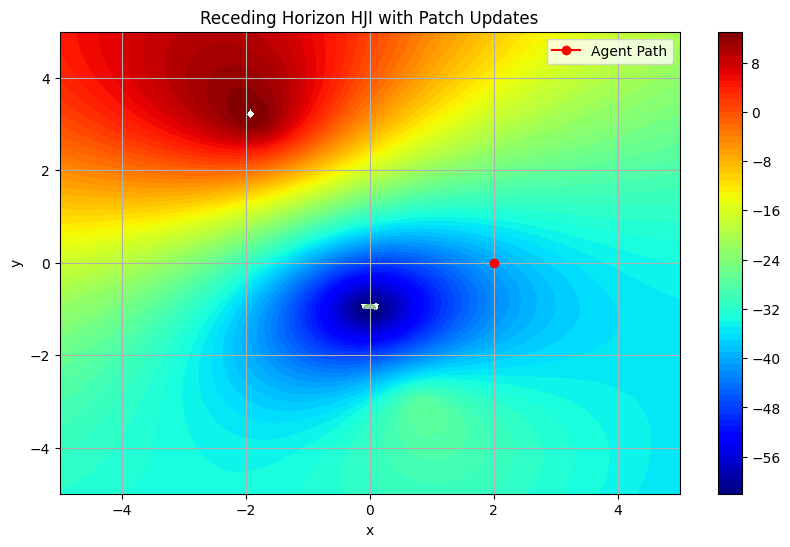

In [121]:
# --- Visualization and Animation ---
vmin, vmax = values.min(), values.max()
levels = jnp.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)

fig, ax = plt.subplots(figsize=(10, 6))
trajectory_np = np.stack(trajectory)

# Obstacles and goal

#reset obstacle and goal positions
obstacles = [
    {"center": [0.8, -3.0], "radius": 0.1},
    {"center": [-1.8, 3.0], "radius": 0.1},
]

goals = [
        {"center": [0.0, -1.0], "radius": 0.1}
        ]


obstacle_patches = []
for obs in obstacles:
    circle = plt.Circle(obs["center"], obs["radius"], color='red', alpha=0.4)
    ax.add_patch(circle)
    obstacle_patches.append(circle)

goal_patches = []
for goal in goals:
    circle = plt.Circle(goal["center"], goal["radius"], color='green', alpha=0.4)
    ax.add_patch(circle)
    goal_patches.append(circle)

agent_dot, = ax.plot([], [], 'ro-', label='Agent Path')

ax.set_title("Receding Horizon HJI with Patch Updates")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)
ax.legend()

# Initial plot to set colorbar
init_contour = ax.contourf(grid.coordinate_vectors[0],
                           grid.coordinate_vectors[1],
                           values_hist[-1][:, :, grid.shape[2] // 2].T, # get value of theta = 0 
                           levels=levels, cmap='jet')
fig.colorbar(init_contour)

contour_ref = [init_contour]

def animate(i):
    for coll in contour_ref[0].collections:
        coll.remove()
    contour = ax.contourf(grid.coordinate_vectors[0],
                          grid.coordinate_vectors[1], 
                          values_hist[i][:, :, grid.shape[2] // 2].T,
                          levels=levels, cmap='jet')
    contour_ref[0] = contour
    agent_dot.set_data(trajectory_np[:i+1, 0], trajectory_np[:i+1, 1])
    return contour.collections + [agent_dot]  + obstacle_patches  +  goal_patches

ani = animation.FuncAnimation(fig, animate, frames=len(values_hist), blit=True)
plt.show()

In [122]:
print(vmax)

13.276339


In [123]:
HTML(ani.to_jshtml())
## Looks pretty cool, following lyapunov stability